In [1]:
import numpy
from matplotlib import pyplot
import matplotlib
import os
import scipy.optimize

pyplot.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
basedir = "markov_data"

In [3]:
exclusion_set = {}
data = {}

for file in sorted(os.listdir(basedir)):
    if file.endswith(".npz"):
        arr = numpy.load(os.path.join(basedir, file))
        L = arr["L"][()]
        if L not in data:
            data[L] = []
        
        data[L].append({key: arr[key] for key in arr._files})

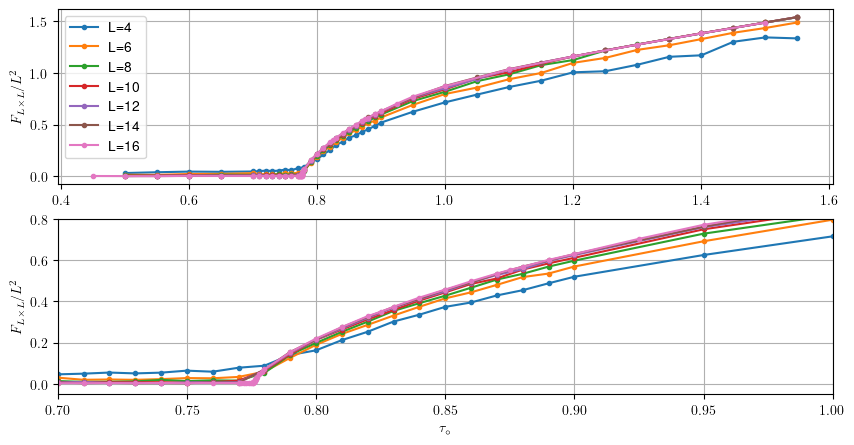

In [4]:
fig, axs = pyplot.subplots(2,1, figsize=(10,5))

for L in sorted(data.keys()):
    all_dat = []
    for d in sorted(data[L], key=lambda d: d["k"][()]):
        k = d["k"][()]
        f = d["free_energy"]
        if len(f) == (L*L + 1):
            lf = d["free_energy"][L*L]/(L*L)
            all_dat.append((k,lf))
    if len(all_dat) > 0:
        axs[0].plot(*zip(*all_dat), '.-', label=f"L={L}")
        axs[1].plot(*zip(*all_dat), '.-', label=f"L={L}")

axs[1].set_xlabel(r"$\tau_\circ$")
axs[0].set_ylabel(r"$F_{L \times L} / L^2$")
axs[1].set_ylabel(r"$F_{L \times L} / L^2$")
axs[1].set_xlim((0.7,1.0))
axs[1].set_ylim((-0.05,0.8))
axs[0].grid()
axs[1].grid()
axs[0].legend()
pyplot.show()

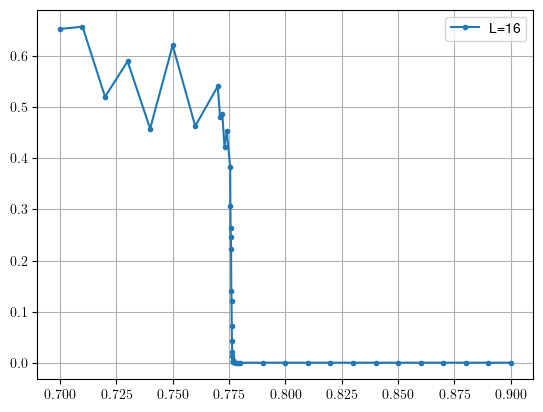

In [9]:
def transform(x, y, L=L, p=1):
    x = numpy.array(x)
    y = numpy.array(y)
    
    
    return x, sum(n**2 * numpy.exp(- y * L*L * abs(n)**2) for n in range(-15, 16)) / sum(numpy.exp(- y * L*L * abs(n)**2) for n in range(-15, 16))

for L in sorted(data.keys()):
    if L != 16:
        continue
    all_dat = []
    for d in sorted(data[L], key=lambda d: d["k"][()]):
        k = d["k"][()]
        f = d["free_energy"]
        if "all_transition_probs" not in d:
            continue
        if d["all_transition_probs"].shape[0] < 4096:
            continue
        if len(f) == (L*L + 1):
            lf = d["free_energy"][L*L]/(L*L)
            all_dat.append((k,lf))
    if len(all_dat) > 0:
        x, y = transform(*zip(*all_dat),L=L)
        pyplot.plot(x, y, '.-', label=f"L={L}")

pyplot.grid()
pyplot.legend()
pyplot.show()

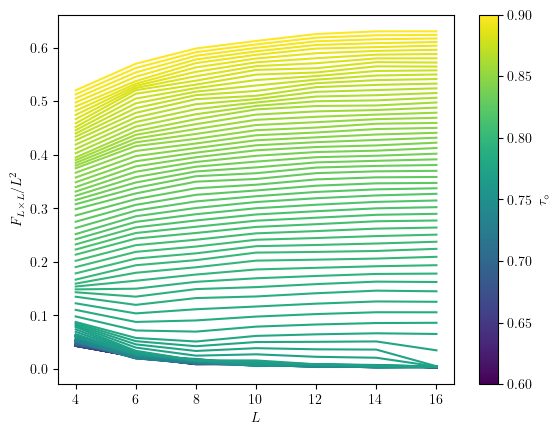

In [6]:
ls = []
dat = []
kmin = 0.6
kmax = 0.9
ks = numpy.linspace(kmin,kmax, 128)

for L in sorted(data.keys()):
    all_dat = []
    for d in sorted(data[L], key=lambda d: d["k"][()]):
        k = d["k"][()]
        f = d["free_energy"]
        if len(f) == (L*L + 1):
            lf = d["free_energy"][L*L]/(L*L)
            all_dat.append((k,lf))
    if len(all_dat) > 0:
        interp = scipy.interpolate.interp1d(*zip(*all_dat))
        dat.append(interp(ks))
        ls.append(L)

dat = numpy.array(dat)
ls = numpy.array(ls)

norm = matplotlib.colors.Normalize(vmin=kmin,vmax=kmax)
colormap = matplotlib.colormaps["viridis"]
cmap = lambda x: colormap(norm(x))

fig, ax = pyplot.subplots()

for k, arr in zip(ks, dat.T):
    ax.plot(ls, arr, c=cmap(k))

ax.set_ylabel(r"$F_{L \times L} / L^2$")
ax.set_xlabel(r"$L$")
fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap='viridis'),
             ax=ax, orientation='vertical', label=r'$\tau_\circ$')
pyplot.show()

/tmp/ipykernel_4993/398224585.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  (a,b,c), pcov = scipy.optimize.curve_fit(lqc, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1],


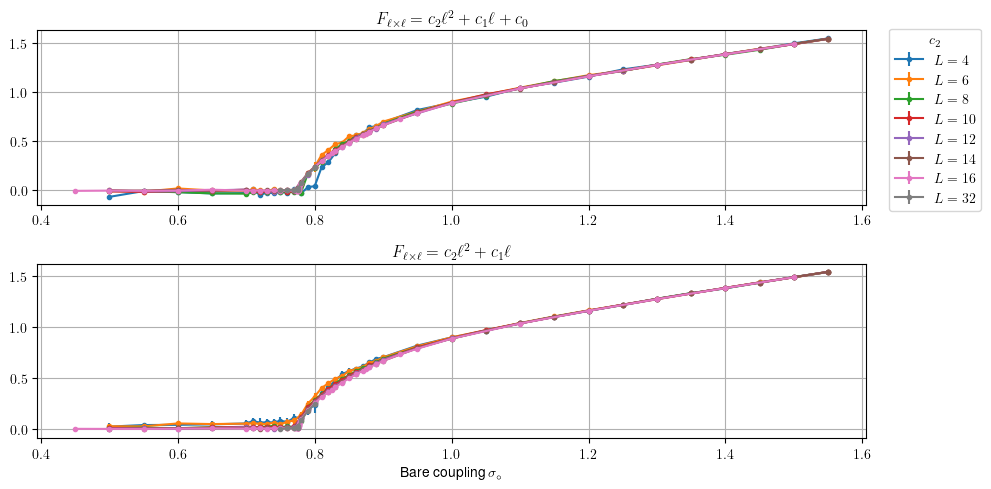

In [7]:
# fit_range_low, fit_range_high = (L//4, (3*L)//2)

def fits_for_range(low, high, L):
    fit_range_low, fit_range_high = low, high
    def lqc(x, a, b, c):
        return c + b*x + a*x*x
    
    def lq(x, a, b):
        return b*x + a*x*x
    
    ks = []
    fits = []
    fits_std = []
    fitsz = []
    fitsz_std = []
    for d in sorted(data[L], key=lambda d: d["k"][()]):
        k = d["k"][()]
        ls = numpy.arange(0,L+1,dtype=numpy.int64)
        ls = ls[ls*ls < len(d["free_energy"])]
        f = numpy.array([d["free_energy"][l*l] for l in ls])
        # fit = numpy.polyfit(ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 2)
        
        (a,b,c), pcov = scipy.optimize.curve_fit(lqc, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 
                                               p0=[0.05,0.05, 0.05])    
        perr = numpy.sqrt(numpy.diag(pcov))
        ks.append(k)
        fits.append([a,b,c])
        fits_std.append(perr)
    
    
        (a,b), pcov = scipy.optimize.curve_fit(lq, ls[fit_range_low:fit_range_high+1], f[fit_range_low:fit_range_high+1], 
                                               p0=[0.05,0.05])
        perr = numpy.sqrt(numpy.diag(pcov))
        fitsz.append([a,b,0])
        fitsz_std.append(perr)
    
    ks = numpy.array(ks)
    fits = numpy.array(fits)
    fits_std = numpy.array(fits_std)
    fitsz = numpy.array(fitsz)
    fitsz_std = numpy.array(fitsz_std)
    return (ks, fits, fits_std, fitsz, fitsz_std)

fig, axs = pyplot.subplots(2, figsize=(10,5))

for L in sorted(data.keys()):
    # if L < 14:
    #     continue
    L = int(L)
    ks, fits, fits_std, fitsz, fitsz_std = fits_for_range(min(2,L//4), (3*L)//4, L)
    
    axs[0].errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label=f"$L={L}$")
    axs[1].errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label=f"$L={L}$")
    
axs[0].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell + c_0$")
axs[0].grid()
axs[0].legend(title="$c_2$", bbox_to_anchor=(1.02,1.05))
axs[1].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell$")
axs[1].grid()
axs[1].set_xlabel(r"Bare coupling $\sigma_{\circ}$")

pyplot.tight_layout()

pyplot.show()

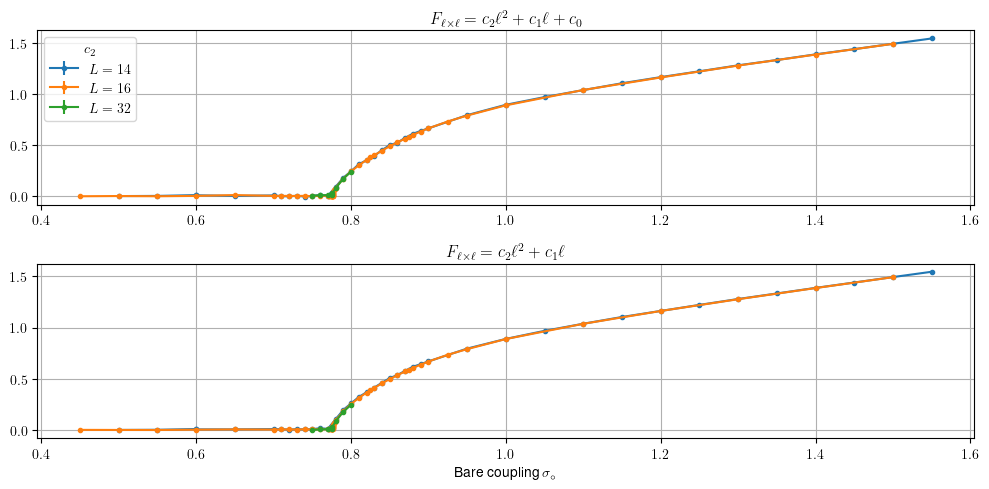

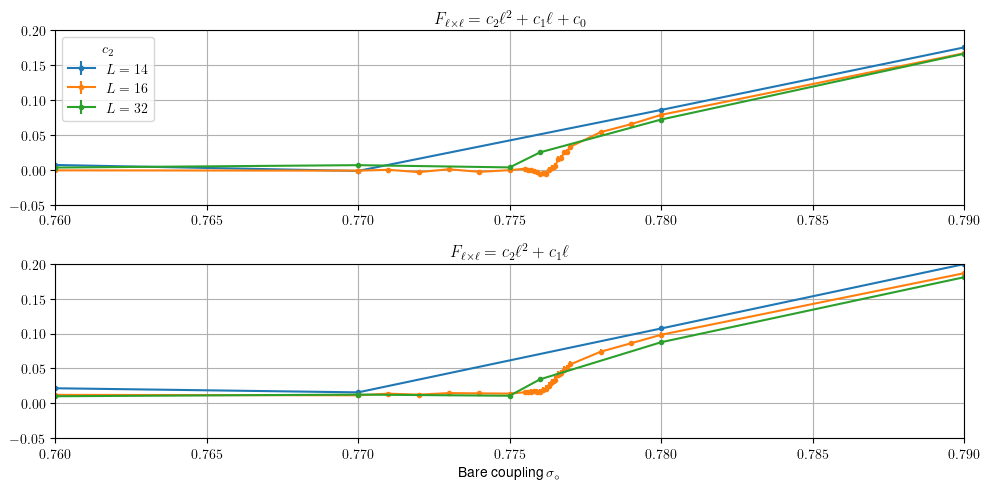

In [8]:
fig, axs = pyplot.subplots(2, figsize=(10,5))

for L in sorted(data.keys()):
    if L < 14:
        continue
    L = int(L)
    ks, fits, fits_std, fitsz, fitsz_std = fits_for_range(2, (3*L)//4, L)
    
    axs[0].errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label=f"$L={L}$")
    axs[1].errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label=f"$L={L}$")
    
axs[0].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell + c_0$")
axs[0].grid()
axs[0].legend(title="$c_2$")
axs[1].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell$")
axs[1].grid()
axs[1].set_xlabel(r"Bare coupling $\sigma_{\circ}$")

pyplot.tight_layout()

pyplot.show()

fig, axs = pyplot.subplots(2, figsize=(10,5))

for L in sorted(data.keys()):
    if L < 14:
        continue
    L = int(L)
    ks, fits, fits_std, fitsz, fitsz_std = fits_for_range(min(2,L//4), (3*L)//4, L)
    
    axs[0].errorbar(ks, fits[:,0], yerr=fits_std[:,0], fmt='.-', label=f"$L={L}$")
    axs[1].errorbar(ks, fitsz[:,0], yerr=fitsz_std[:,0], fmt='.-', label=f"$L={L}$")
    
axs[0].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell + c_0$")
axs[0].grid()
axs[0].legend(title="$c_2$")
axs[1].set_title(r"$F_{\ell \times \ell} = c_2 \ell^2 + c_1 \ell$")
axs[1].grid()
axs[1].set_xlabel(r"Bare coupling $\sigma_{\circ}$")

axs[0].set_xlim((0.76,0.79))
axs[0].set_ylim((-0.05,0.2))
axs[1].set_xlim((0.76,0.79))
axs[1].set_ylim((-0.05,0.2))
pyplot.tight_layout()

pyplot.show()